In [3]:
import cv2
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from glob import iglob
from pandas import read_excel

In [2]:
# class Bag:
#     # Bag => WSI image cropped shuffled set
#     # Instance => mixed_patches
#     def __init__(
#         self,
#         excel_path=r"patient-clinical-data.xlsx",
#         patches_path=r"patches",
#         classification_label="ER",
#         positive_label="Positive",
#         bag_size=30, # Median of patches size is 36.5 FYI
#     ) -> None:
#         self.csv_data = pd.read_excel(excel_path)
#         self.patch_folder = sorted(iglob(patches_path + "/*"))
#         self.patch_label = list(
#             map(
#                 lambda x: 1 if x == positive_label else 0,
#                 self.csv_data[classification_label],
#             )
#         )
#         self.bag_size = bag_size
#         print("Initialising")
#         print("labelling patch")
#         self.__patch_labelling()
#         print("generating bags")
#         self.__gen_bags()
#         print("finished generation")
#         self.bag_list = []
#         self.bag_list.extend(zip(self.pos_bag_list, torch.ones(len(self.pos_bag_list))))
#         self.bag_list.extend(zip(self.neg_bag_list, torch.zeros(len(self.neg_bag_list))))
#         shuffle(self.bag_list)

#     def __patch_labelling(self):
#         self.unlabeled_img = []
#         transform = transforms.Compose(
#             [
#                 transforms.Resize((256, 256)),
#                 transforms.ToTensor(),
#             ]
#         )
#         for folder in self.patch_folder:
#             patch_img = []
#             file_path = sorted(iglob(folder + "/*"))
#             for img_path in file_path:
#                 # ? Change it back to Pillow open and also pytorch transform and pytorch to_tensor()
#                 patch_img.append(transform(Image.open(img_path)))
#             self.unlabeled_img.append(patch_img)

#         # self.labeled_img = []
#         # for patch_idx, patch in enumerate(self.unlabeled_img):
#         #     self.labeled_img.extend(zip(patch,list[self.patch_label[patch_idx]*len(patch)]))
#         # self.pos_instance = []
#         # self.neg_instance = []
#         # for img,label in self.labeled_img:
#         #     if label:
#         #         self.pos_instance.append(img)
#         #     else:
#         #         self.neg_instance.append(img)

#         self.pos_instance = []
#         self.neg_instance = []
#         for patch_idx, patch in enumerate(self.unlabeled_img):
#             if self.patch_label[patch_idx]:
#                 self.pos_instance.extend(patch)
#             else:
#                 self.neg_instance.extend(patch)
#         ratio = len(self.pos_instance) / (
#             len(self.pos_instance) + len(self.neg_instance)
#         )
#         self.pos_neg_ins_ratio = (ratio, ratio + 0.1)

#     def __gen_bags(self):
#         self.pos_bag_list = []
#         self.neg_bag_list = []
#         # Generate Positive Bags
#         for i in range(np.count_nonzero(self.patch_label)):
#             bag = []
#             try:
#                 bag_size = np.random.randint(*self.bag_size)
#             except:
#                 bag_size = self.bag_size
#             pos_size = round(
#                 (
#                     np.random.random()
#                     * (self.pos_neg_ins_ratio[1] - self.pos_neg_ins_ratio[0])
#                     + self.pos_neg_ins_ratio[0]
#                 )
#                 * bag_size
#             )
#             for j in range(pos_size):
#                 if self.pos_instance:
#                     bag.append(self.pos_instance.pop(0)[0])
#                 else:
#                     break
#             for j in range(bag_size - len(bag)):
#                 if self.neg_instance:
#                     bag.append(self.neg_instance.pop(0)[0])
#                 else:
#                     break
#             self.pos_bag_list.append(bag)
#         neg_index_list = []
#         for i in range(len(self.patch_label) - np.count_nonzero(self.patch_label)):
#             bag = []
#             try:
#                 bag_size = np.random.randint(*self.bag_size)
#             except:
#                 bag_size = self.bag_size
#             for j in range(bag_size):
#                 if self.neg_instance:
#                     tmp_instance = self.neg_instance.pop(0)
#                     bag.append(tmp_instance[0])
#                     neg_index_list.append(tmp_instance[1])
#                 else:
#                     break
#             self.neg_bag_list.append(bag)
#         # print(neg_index_list)

#         shuffle(self.pos_bag_list)
#         shuffle(self.neg_bag_list)


In [3]:
# bag = Bag(
#     excel_path=r"patient-clinical-data.xlsx",
#     patches_path=r"patches",
#     classification_label="ER",
#     positive_label="Positive",
#     bag_size=30,
# )


In [12]:

class Bag_WSI:
    # Bag => WSI image cropped shuffled set
    # Instance => mixed_patches
    def __init__(
        self,
        excel_path=r"patient-clinical-data.xlsx",
        patches_path=r"patches",
        classification_label="ER",
        positive_label="Positive",
        bag_size=30,  # Median of patches size is 36.5 FYI
    ) -> None:
        self.csv_data = read_excel(excel_path)
        self.patch_folder = sorted(
            iglob(patches_path + "/*"), key=lambda x: int(x.split("/")[-1])
        )
        self.patch_label = list(
            map(
                lambda x: 1 if x == positive_label else 0,
                self.csv_data[classification_label],
            )
        )
        self.bag_size = bag_size
        print("Initialising")
        self.__patch_labelling()
        print("finished generation")
        self.bag_list = list(
            [
                *zip(self.pos_bag_list, torch.ones(len(self.pos_bag_list), 1)),
                *zip(self.neg_bag_list, torch.zeros(len(self.neg_bag_list), 1)),
            ]
        )

    def __patch_labelling(self):
        unlabeled_img_list = []
        self.pos_bag_list = []
        self.neg_bag_list = []
        transform = transforms.Compose(
            [
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                # ? Need normalised the image?
            ]
        )
        for folder in self.patch_folder:
            # print(folder)
            patch_img = []
            file_path = iglob(folder + "/*")
            for img_path in file_path:
                patch_img.append(transform(Image.open(img_path)))
            unlabeled_img_list.append(torch.stack(patch_img, dim=0))
        for patch_idx, patch in enumerate(unlabeled_img_list):  # patch is tensor
            # * Check Patch Tensor Length
            if len(patch) <= self.bag_size:
                # * Generate a bag directly, can write a function to make it look better
                if self.patch_label[patch_idx]:
                    self.pos_bag_list.append(patch)
                else:
                    self.neg_bag_list.append(patch)
            else:
                # * Generate multiple bags with random sampled instances, number of bags depend on the number of instances the patch have.
                bootstrap_times = len(patch) // self.bag_size + 1
                for i in range(bootstrap_times):
                    rand_int = torch.multinomial(
                        torch.ones(self.bag_size, dtype=torch.float),
                        self.bag_size,
                        replacement=True,
                    )
                    bag = patch[rand_int]  # 1 * N(img) * 3 * 255 * 255
                    if self.patch_label[patch_idx]:
                        self.pos_bag_list.append(bag)
                    else:
                        self.neg_bag_list.append(bag)


In [13]:
bag_wsi = Bag_WSI(
    excel_path=r"patient-clinical-data.xlsx",
    patches_path=r"patches",
    classification_label="ER",
    positive_label="Positive",
    bag_size=30,
)


Initialising
finished generation


<class 'torch.Tensor'>
tensor([0.])


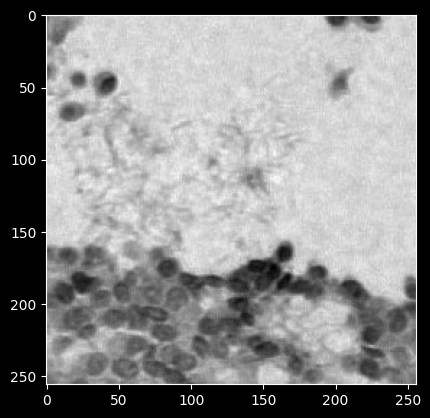

In [28]:
import matplotlib.pyplot as plt
print(type(bag_wsi.bag_list[0][0][0]))
print(bag_wsi.bag_list[-1][1])
plt.imshow(bag_wsi.bag_list[0][0][0].numpy()[-1],cmap='gray')

![vgg](../BALNMP/imgs/vgg16.png)

![img](../BALNMP/imgs/b.png)

(2) Feature extraction (left part of Figure 2b). N feature vectors were extracted for the N image instances in each bag by using a convolutional neural network (CNN) model.

(3) MIL (right part of Figure 2b).The extracted N feature vectors of image instances were first processed by the max-pooling(already finished in vgg16_bn, please see the following [link](https://www.google.com/url?sa=i&url=https%3A%2F%2Fneurohive.io%2Fen%2Fpopular-networks%2Fvgg16%2F&psig=AOvVaw2Z-N_QJmi_T9Q3lVSHTYnl&ust=1665024222296000&source=images&cd=vfe&ved=0CAwQjRxqFwoTCICO_9yIyPoCFQAAAAAdAAAAABAD) for more information) **[Feng and Zhou, 2017, Pinheiro and Collobert, 2015, Zhu et al., 2017]** and reshaping and then were passed to a two-layer fully connected (FC) layer. The N weight factors for the instances in the bag were thus obtained and then were further multiplied to the original feature vectors [Ilse et al., 2018] to adaptively adjust the effect of instance features.Then, the fused features were fed into the classifier, and the outputs and the ground truth labels were used to calculate the cross-entropy loss. 

(4) Model training and testing. We randomly divided the WSIs into training cohort and independent test cohort with the ratio of 4:1 and randomly selected 25% of the training cohort as the validation cohort. We used Adam optimizer with learning rate 1e-4 to update the model parameters and weight decay 1e-3 for regularization. In the training phase, we used the cosine annealing warm restarts strategy to adjust the learning rate [Loshchilov and Hutter, 2017]. In the testing phase, the ALN status is predicted by aggregating the model outputs of all bags from the same slide (Figure 2c). 

In [9]:
from torch import nn
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Only use the CNN part and flatten part for vgg16_bn, without using the last classifier
        vgg16_bn = torchvision.models.__dict__['vgg16_bn'](weights='DEFAULT')
        self.extractor = nn.Sequential(*(list(vgg16_bn.children())[:-1]))
        self.output_features_size = 512 * 7 * 7 # C * H * W
    
    def forward(self,x):
        # TODO: The vgg16_bn will autometically run on all different images?
        feat = self.extractor(x)
        # print('feat.shape = ',feat.shape) # N * 512 * 7 * 7
        return feat
    
class FeatureAggregator(nn.Module):
    def __init__(self,cnn_output_features_size) -> None:
        super().__init__()
        self.pink_size = 256
        self.white_size = 128
        # FC: 1*(512*7*7) -> 256
        # Attention: 256 -> 1
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_features_size,self.pink_size),
            nn.Dropout(),
            nn.LeakyReLU()
        )
        # I dont understand why the attention layer should write like this.
        self.attention = nn.Sequential(
            nn.Linear(self.pink_size, self.white_size),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(self.white_size, 1),
            nn.Dropout()
            # No need another activation function as we will have softmax later in the forward part.
        )
    def forward(self,x):
        x = x.view(-1, 512*7*7) # Flatten into N Column(512*7*7)
        x = self.fc(x) # N * (1 * 256)
        
        a = self.attention(x) #　N * 1
        a = a.T #should be N*1 -> 1*N i think???
        a = torch.softmax(a,dim=1)
        
        m = torch.mm(a , x) # 1*N x N*128 = 1*128
        return m
    
class MIL(nn.Module):
    def __init__(self,):
        super(MIL, self).__init__()
        # vgg16_bn without last classification layer
        self.cnn = CNN()
        self.attention = FeatureAggregator(self.cnn.output_features_size)

        self.fc = torch.nn.Sequential(
            nn.Linear(self.attention.pink_size, 64),
            nn.LeakyReLU(),
            nn.Linear(64,2),
            nn.Sigmoid()
            # Sigmoid?
        )

    def forward(self, bag):
        feat = self.cnn(bag) # N * 3 * 256 * 256 -> N * 512 * 7 * 7
        post_attention_feat = self.attention(feat)
        x = self.fc(post_attention_feat)
        # print(x)
        return x

In [28]:
num_bag = len(bag_wsi.bag_list)
train_bags, test_bags = torch.utils.data.random_split(
    bag_wsi.bag_list, [round(0.01 * num_bag), round(0.99 * num_bag)]
)
train_patch, train_label = [i[0] for i in train_bags],[i[1] for i in train_bags]
test_patch, test_label = [i[0] for i in test_bags],[i[1] for i in test_bags]

mil = MIL()
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mil.parameters())


In [32]:
for epoch in range(1):
    running_loss = 0.0
    count = 0
    for patch, label in train_bags:
        count += 1
        optimizer.zero_grad()
        # print('patch length: ',len(patch))
        bag_class = mil(patch)
        loss = loss_func(bag_class,label.to(torch.long))
        print(loss,bag_class,label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if count % 20 == 19:
            print(f"[{epoch + 1}, {count + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

tensor(0.7414, grad_fn=<NllLossBackward0>) tensor([[0.0118, 0.1061]], grad_fn=<AddmmBackward0>) tensor([0.])
tensor(2.4978, grad_fn=<NllLossBackward0>) tensor([[ 1.7371, -0.6749]], grad_fn=<AddmmBackward0>) tensor([1.])
tensor(0.6506, grad_fn=<NllLossBackward0>) tensor([[0.0680, 0.1549]], grad_fn=<AddmmBackward0>) tensor([1.])
tensor(0.4960, grad_fn=<NllLossBackward0>) tensor([[-0.0854,  0.3575]], grad_fn=<AddmmBackward0>) tensor([1.])
tensor(0.0908, grad_fn=<NllLossBackward0>) tensor([[-1.0005,  1.3533]], grad_fn=<AddmmBackward0>) tensor([1.])
tensor(6.0795e-05, grad_fn=<NllLossBackward0>) tensor([[-4.5685,  5.1401]], grad_fn=<AddmmBackward0>) tensor([1.])
tensor(17.9399, grad_fn=<NllLossBackward0>) tensor([[-8.2897,  9.6502]], grad_fn=<AddmmBackward0>) tensor([0.])
tensor(0.0016, grad_fn=<NllLossBackward0>) tensor([[-3.0633,  3.3722]], grad_fn=<AddmmBackward0>) tensor([1.])
tensor(0.0037, grad_fn=<NllLossBackward0>) tensor([[-1.9154,  3.6935]], grad_fn=<AddmmBackward0>) tensor([1.])


In [2]:
import torch
a = torch.zeros((2,1))
print(a)

tensor([[0.],
        [0.]])
